# Load Data



## Set env variables

assumes that `SOCRATA_APP_TOKEN`, `SOCRATA_API_KEY_ID`, and `SOCRATA_API_KEY_SECRET` are set in `.env`

In [1]:
from dotenv import load_dotenv

load_dotenv()


True

## Load Packages

In [ ]:
import os
import sys

PACKAGE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, PACKAGE_PATH)

from src import config
from src import preprocessing
from src import plotting
from src import features



In [3]:
import pandas as pd
import numpy as np

import geopandas as gpd
from shapely.geometry import Point

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, date

## Load Raw Data

In [4]:
df = preprocessing.load_dohmh_data()

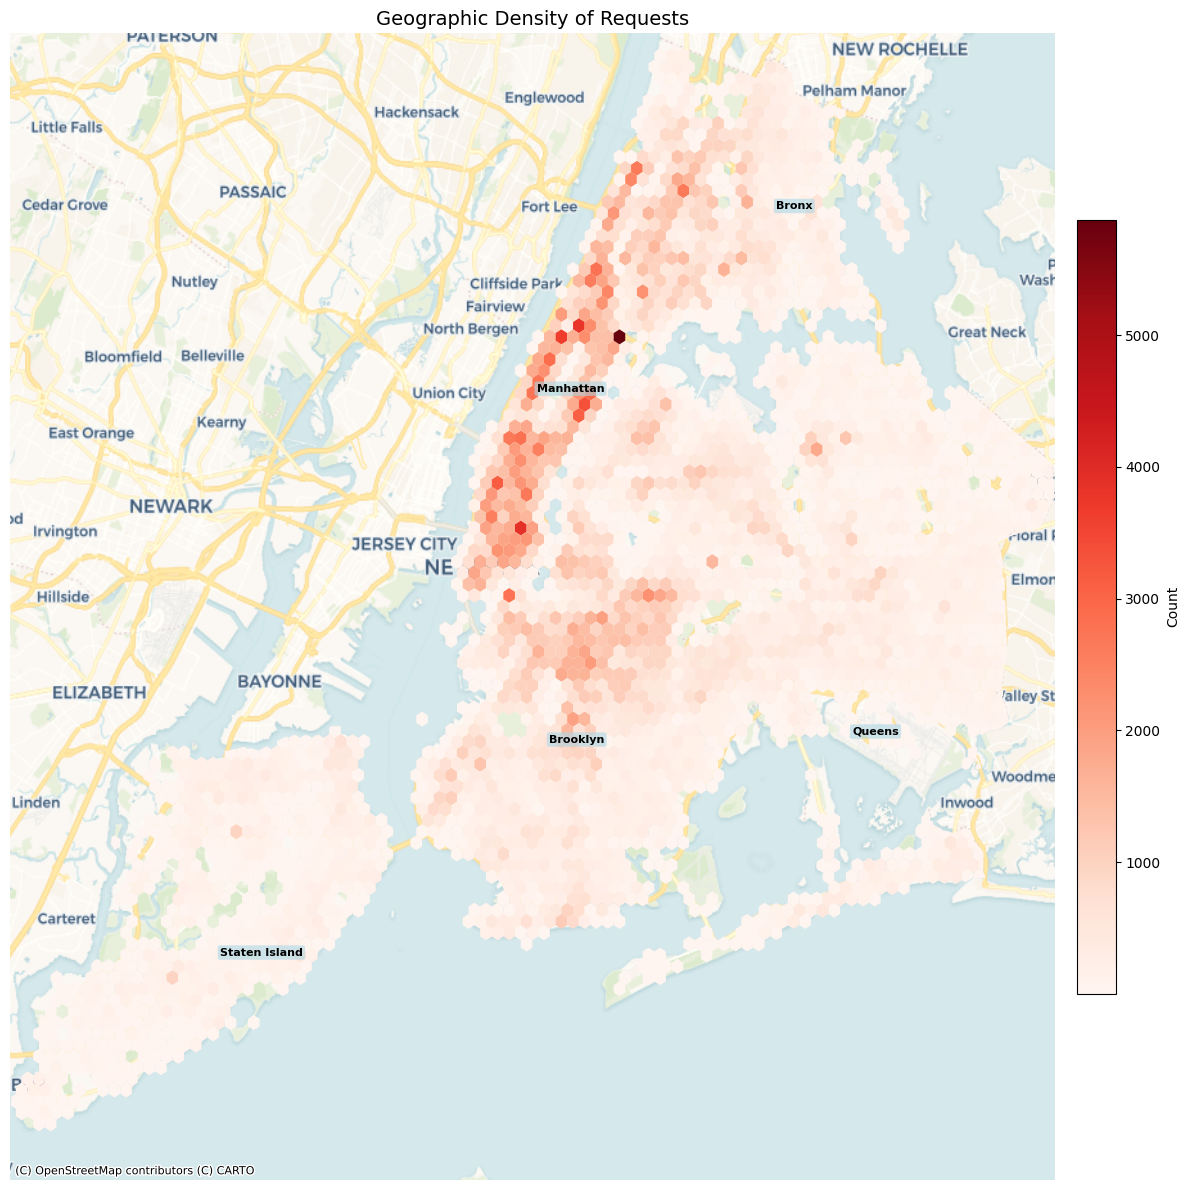

In [5]:
# Example usage with the existing data
fig, ax = plotting.create_hexbin_density_map(
    df, 
    lat_col='latitude', 
    lon_col='longitude',
    title="Geographic Density of Requests",
)
plt.show()


## Load Preprocessed Data

In [6]:
df = preprocessing.preprocess_and_merge_external_data()

Loading DOHMH data...
Data Shape: (1029643, 26)
Preprocessing DOHMH data...
Data Shape: (617637, 43)
Merging census data...
Data Shape: (617637, 47)
Merging weather data...
Data Shape: (604427, 52)

Final Data Shape: (604427, 52)


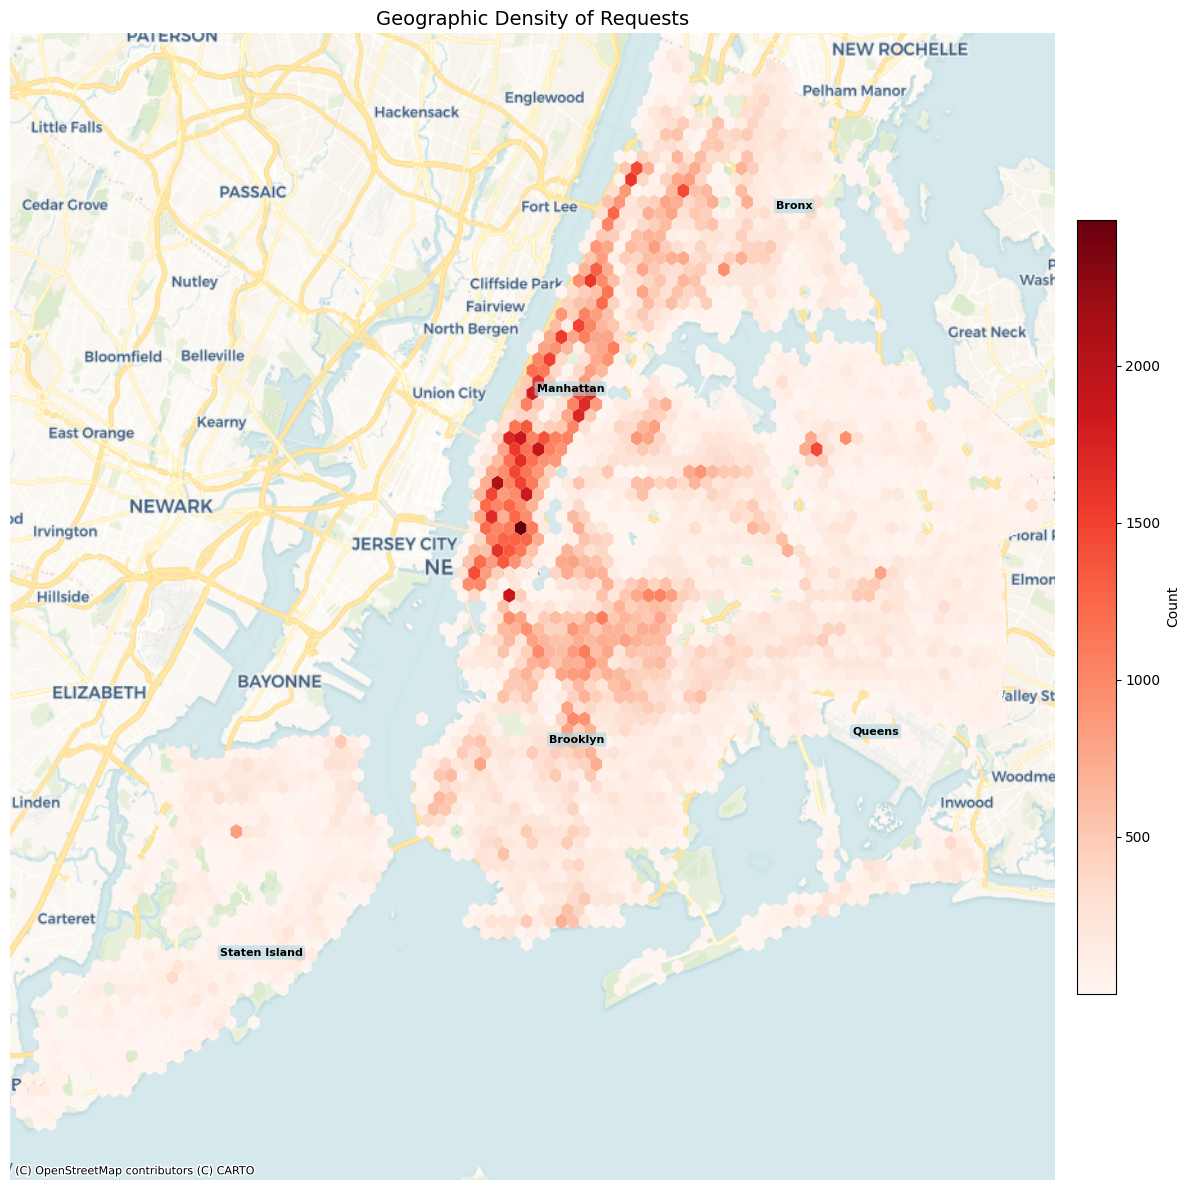

In [7]:
# Example usage with the existing data
fig, ax = plotting.create_hexbin_density_map(
    df, 
    lat_col='latitude', 
    lon_col='longitude',
    title="Geographic Density of Requests",
)
plt.show()


### Data Transformation

In [ ]:
df = features.add_h3_keys(df, lat='latitude', lon='longitude', res=8)
forecast_panel = features.build_forecast_panel(df)